# Plot Test Results

In [24]:
# import necessary libraries
import os
import json
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt

import DLRCP.theoreticalAnalysis as theoTool

In [25]:
# Mapping between official name and alias in scripts
protocolName = {
    'UDP': 'UDP',
    'ARQ_inf_wind': 'ARQ',
    'ARQ_finit_wind': 'ARQ finit window',
    'TCP': 'TCP',
    'RCPQ_Learning': 'RTQ',
    'RCPRTQ': 'optimal-RCP' 
}

attributeNameDict = {
        "protocol": "ptcl",
        "generated packets": "pkts gen",
        "sent packets": "pkts sent",
        "packets delivered": "pkts dlvy",
        "delivery percentage": "dlvy perc",
        "average delay": "avg dly",
        "system utility": "sys util",
        "packets delivered (last 25%)": "l25p dlvy",
        "delivery percentage (last 25%)": "l25p dlvy perc",
        "average delay (last 25%)": "l25p dly",
        "system utility (last 25%)": "l25p util",
        "loss": "loss"
}

In [26]:
# specify test result subfolder and trial folder prefix
# resultFolder, subFolderPrefix = "Results/case_newutility_SumPower_alpha_2_0", "SumPower"
# resultFolder, subFolderPrefix = "Results/case_study_competition_TimeDiscount_alpha_2_0", "TimeDiscount"
# resultFolder, subFolderPrefix = "Results/case_study_TimeDiscount_alpha_2_0", "TimeDiscount"
resultFolder, subFolderPrefix = "Results/dynamic_channel_TimeDiscount_alpha_2_0", "TimeDiscount"


In [27]:
# figure out the path to each beta value
subFolders = os.listdir(resultFolder)
subFolders = filter(lambda s: s.startswith(subFolderPrefix), subFolders)


In [28]:
subFolderBetaMap_unordered = {}
for subfolder in subFolders:
    betaList = subfolder.split("_")
    if len(betaList) > 1:
        betaStr = "".join(subfolder.split("_")[1:])
        beta = int(betaStr) / (10 ** (len(betaStr)-1))
        subFolderBetaMap_unordered[subfolder] = {"beta": beta}
del subFolders


In [29]:
# order subFolder based on beta value (the second element in the dict.item)
subFolderBetaMap = dict(sorted(subFolderBetaMap_unordered.items(), key=lambda x: x[1]["beta"]))

In [30]:
# get the performance pkl of RCPRTQ_perf
pklPath = os.path.join(resultFolder, list(subFolderBetaMap.keys())[7], "RCPRTQ_perf.pkl")
print(pklPath)
if os.path.isfile(pklPath):
    with open(pklPath, 'rb') as f:
        data = pkl.load(f)
    print(data.keys())

Results/dynamic_channel_TimeDiscount_alpha_2_0/TimeDiscount_0_8_0/RCPRTQ_perf.pkl
dict_keys(['perfRecords', 'serverSidePerf', 'clientSidePerf', 'clientPid', 'distincPktsSent', 'pktsPerTick', 'delayPerPkt'])


In [31]:
def interpretData(data):
    perfRecord = np.asarray(data["perfRecords"])
    svrPerfDf = pd.DataFrame({
        "time": perfRecord[:, 0],
        "delivered pkt since before": perfRecord[:, 1],
        "pkt delivery rate": perfRecord[:, 2],
        "avg delay": perfRecord[:, 3],
        "utility": perfRecord[:, 4]
        })
    
    svrPktID, svrPktDelvyRate, svrAvgDelay = data["serverSidePerf"]

    cltPerfDf = pd.DataFrame({
        "retransSoFar": data["clientSidePerf"]["retransSoFar"], 
        "retransProb": data["clientSidePerf"]["retransProbSoFar"], 
        "ignorePktsSoFar": data["clientSidePerf"]["ignorePktsSoFar"], 
        })
    
    return {
        "serverPerfDf": svrPerfDf,
        "clientPerfDf": cltPerfDf,
        "perfRecord": perfRecord
    }
    
# interpretData(data)

In [32]:
"""
Let you know what's inside a "data" data structure.
"""

# def showDictHierarchy(data, prefix="", level=0):
#     if isinstance(data, dict):
#         print("  "*level+prefix)
#         for key in data:
#             showDictHierarchy(data[key], str(key), level+1)
#     else:
#         print("  "*(level) + prefix + ":" + str(type(data)))
# showDictHierarchy(data)

'\nLet you know what\'s inside a "data" data structure.\n'

## Load all data

In [33]:
# load RTQ
for subFolder in subFolderBetaMap:
    name = protocolName["RCPRTQ"]
    pklPath = os.path.join(resultFolder, subFolder, "RCPRTQ_perf.pkl")
    if os.path.isfile(pklPath):
        with open(pklPath, 'rb') as f:
            data = pkl.load(f)
        subFolderBetaMap[subFolder][name] = interpretData(data)

    name = protocolName["RCPQ_Learning"]
    pklPath = os.path.join(resultFolder, subFolder, "RCPQ_Learning_perf.pkl")
    if os.path.isfile(pklPath):
        with open(pklPath, 'rb') as f:
            data = pkl.load(f)
        subFolderBetaMap[subFolder][name] = interpretData(data)


### Plot retransmission rate vs beta plot

In [34]:
retransProbVsBetaData = {
    "beta": [subFolderBetaMap[subFolder]["beta"] for subFolder in subFolderBetaMap]
}

if protocolName["RCPRTQ"] in subFolderBetaMap[subFolder]:
    retransProbVsBetaData[protocolName["RCPRTQ"]] = [subFolderBetaMap[subFolder][protocolName["RCPRTQ"]]["clientPerfDf"]["retransProb"].iloc[-1] for subFolder in subFolderBetaMap]

if protocolName["RCPQ_Learning"] in subFolderBetaMap[subFolder]:
    retransProbVsBetaData[protocolName["RCPQ_Learning"] + "_middle"] = [subFolderBetaMap[subFolder][protocolName["RCPQ_Learning"]]["clientPerfDf"]["retransProb"].iloc[20000] for subFolder in subFolderBetaMap]

    retransProbVsBetaData[protocolName["RCPQ_Learning"] + "_final"] = [subFolderBetaMap[subFolder][protocolName["RCPQ_Learning"]]["clientPerfDf"]["retransProb"].iloc[-1] for subFolder in subFolderBetaMap]


retransProbVsBetaDf = pd.DataFrame(data=retransProbVsBetaData)
retransProbVsBetaDf.set_index("beta", inplace=True)

In [35]:
retransProbVsBetaDf = retransProbVsBetaDf.rename(columns={"RTQ_middle": "RTQ", "RTQ_final": "RTQ-final"})

In [36]:
retransProbVsBetaDf

,optimal-RCP,RTQ,RTQ-final
beta,,,
0.1,2.451677e-71,2.079851e-31,1.229385e-66
0.2,9.025630e-17,6.296501e-30,2.320647e-65
0.3,6.326956e-01,1.450260e-31,4.328075e-67
0.4,6.120760e-01,2.410272e-26,1.607309e-61
0.5,8.047634e-01,6.313030e-01,6.078521e-01
0.6,8.335863e-01,6.433931e-01,6.537472e-01
0.7,9.267909e-01,7.898260e-01,8.192034e-01
0.8,9.166233e-01,9.549548e-01,8.382332e-01
0.9,9.670173e-01,9.423422e-01,9.517170e-01


Text(0, 0.5, 'Retransmission Probability')

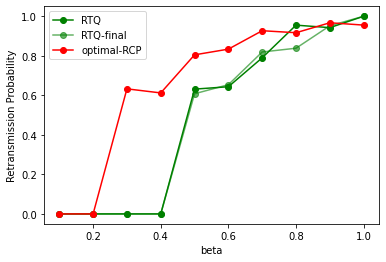

In [37]:
protocolPlotSettings = {"RTQ": ['g-o', 1], "RTQ-final": ['g-o', 0.6], "optimal-RCP": ['r-o', 1]}
for protocol in protocolPlotSettings:
    plt.plot(retransProbVsBetaDf.index, retransProbVsBetaDf[protocol], protocolPlotSettings[protocol][0], alpha=protocolPlotSettings[protocol][1], label=protocol)
plt.legend()
plt.xlabel("beta")
plt.ylabel("Retransmission Probability")

Retransmission Probability over time

In [38]:
retransProbOverTime_RTQ = [subFolderBetaMap[subFolder][protocolName["RCPQ_Learning"]]["clientPerfDf"]["retransProb"] for subFolder in subFolderBetaMap]
retransProbOverTime_RCP = [subFolderBetaMap[subFolder][protocolName["RCPRTQ"]]["clientPerfDf"]["retransProb"] for subFolder in subFolderBetaMap]

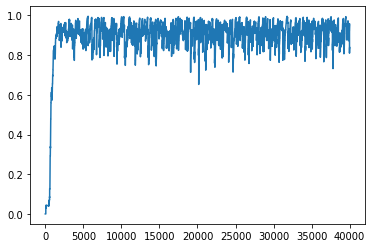

In [54]:
plt.plot(retransProbOverTime_RTQ[7])

## Plot Utility vs Beta

In [40]:
utilityVSBetaData = {
    "beta": [subFolderBetaMap[subFolder]["beta"] for subFolder in subFolderBetaMap]
}
if protocolName["RCPRTQ"] in subFolderBetaMap[subFolder]:
    utilityVSBetaData[protocolName["RCPRTQ"]] = [subFolderBetaMap[subFolder][protocolName["RCPRTQ"]]["serverPerfDf"]["utility"].iloc[-1] for subFolder in subFolderBetaMap]

if protocolName["RCPQ_Learning"] in subFolderBetaMap[subFolder]:
    # utilityVSBetaData[protocolName["RCPQ_Learning"] + "_middle"] = [subFolderBetaMap[subFolder][protocolName["RCPQ_Learning"]]["serverPerfDf"]["utility"].iloc[20000] for subFolder in subFolderBetaMap]

    utilityVSBetaData[protocolName["RCPQ_Learning"] + "_final"] = [subFolderBetaMap[subFolder][protocolName["RCPQ_Learning"]]["serverPerfDf"]["utility"].iloc[-1] for subFolder in subFolderBetaMap]

utilityVSBetaDf = pd.DataFrame(data=utilityVSBetaData)
utilityVSBetaDf.set_index("beta", inplace=True)

<AxesSubplot:xlabel='beta'>

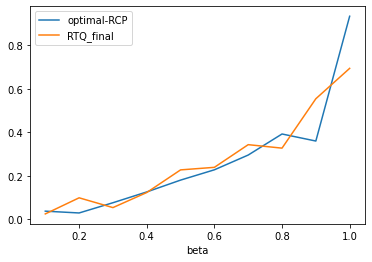

In [41]:
utilityVSBetaDf.plot()

## Summary of Q table

In [42]:
betaIdx=5
alpha = 2
subFolder = list(subFolderBetaMap.keys())[betaIdx]
beta = subFolderBetaMap[subFolder]["beta"]

QDebugFile = os.path.join(resultFolder, subFolder, "QTable.txtdebug.csv")
QTableFile = os.path.join(resultFolder, subFolder, "QTable.txt")
# QDebugFile = 'Results/case_study_TimeDiscount_alpha_2_0/TimeDiscount_{}_{}/QTable.txtdebug.csv'.format(beta_digit1, beta_digit2)
# QTableFile = 'Results/case_study_TimeDiscount_alpha_2_0/TimeDiscount_{}_{}/QTable.txt'.format(beta_digit1, beta_digit2)
# print(QDebugFile)
df = pd.read_csv(QDebugFile)
QTable = pd.read_csv(QTableFile, names=['a=0', 'a=1'])

In [43]:
delays_exp = df['curDelay'].mean()
deliveryRate_exp = df['curDelvyRate'].mean()
delays_lst25_exp = df['curDelay'][-1000:].mean()
deliveryRate_lst25_exp = df['curDelvyRate'][-1000:].mean()

gamma_exp = df['curChPktLoss'].mean()
txAttempts = df['curTxAttemp']
RTT_exp = df['curRTT'].mean()
RTO_exp = df['curRTO'].mean()
RTTVar_exp = df['curRTTVar'].mean()

In [44]:
def utilityCalcHandler(delvyRate, avgDelay):
    return beta ** (avgDelay / 100) * (delvyRate ** alpha)

In [45]:
# calculate s from QTable
s_exp = (QTable['a=1'] > QTable['a=0']).sum()

# channelPktLossRate = 0.3
# channelDelay = 125
# channelRTO = 125 + 50/4 * 4

channelPktLossRate = gamma_exp
channelDelay = RTT_exp
# channelRTO = RTO_exp
channelRTO = RTO_exp

smax=30
utility_list = []
delay_list = []
delvy_list = []
for rx in range(1, smax):
    avgDelay = theoTool.calc_delay_expect(channelPktLossRate, channelDelay, channelRTO, rx)
    avgDeliveryRate = theoTool.calc_delvy_rate_expect(channelPktLossRate, rx)
    
    delvy_list.append(avgDeliveryRate)
    delay_list.append(avgDelay)
    utility_list.append(utilityCalcHandler(
        delvyRate=avgDeliveryRate,
        avgDelay=avgDelay,
    ))


s_theory = np.argmax(utility_list) + 1 # because rx starts from 1
best_s_list = ['' if s != s_theory else 'best' for s in range(1, smax) ]

utility_for_each_s = pd.DataFrame({'s': list(range(1, smax)), 'delay': delay_list, 'delivery rate': delvy_list, 'utility': utility_list, 'best s': best_s_list})
utility_for_each_s

,s,delay,delivery rate,utility,best s
0,1,123.816068,0.517738,0.142408,
1,2,180.320133,0.767423,0.234440,
2,3,219.764715,0.887837,0.256520,best
3,4,245.859789,0.945908,0.254836,
4,5,262.326156,0.973913,0.248355,
5,6,272.308872,0.987419,0.242599,
6,7,278.164278,0.993933,0.238567,
7,8,281.507904,0.997074,0.236011,
8,9,283.376349,0.998589,0.234480,
9,10,284.402368,0.999319,0.233596,


In [46]:
# delay and delivery rate from data
delays_exp, deliveryRate_exp, delays_lst25_exp, deliveryRate_lst25_exp

(213.08267370272648, 0.7377595426561124, 213.554, 0.746717)

In [47]:
# v from theory

# RTQ_v, _ = theoTool.calc_V_theo_norm(RTQ_pktLossRate, timeDivider, alpha, beta, RTQ_delay, RTQ_delay_var, maximumSimulationSmax)
# RTQ_v, _ = theoTool.calc_V_theo_uniform(RTQ_pktLossRate, timeDivider, alpha, beta, RTQ_delay-2*RTQ_delay_var, RTQ_delay+2*RTQ_delay_var, maximumSimulationSmax)

v_theory, s_theory = theoTool.calc_V_theo_norm(gamma_exp, 100, alpha, beta, RTT_exp, RTTVar_exp, smax)
# {'Q - theory': v_theory, 'Q-exp': QTable[:, 1]}
q_theory = np.zeros((smax, 2))
q_theory[:, 0] = v_theory[s_theory]
q_theory[:s_theory, 1] = v_theory[:s_theory]
s_theory_list = ['' if s != (s_theory-1) else '*' for s in range(0, smax) ]
exp_vs_theory_v = pd.DataFrame({'Q-theory:a=0': q_theory[:, 0], 'Q-theory:a=1': q_theory[:, 1], 'Q-theory: s*': s_theory_list})

v_exp = QTable
v_exp.reset_index()
s_exp_list = ['' if s != (s_exp-1) else '*' for s in range(0, smax) ]


exp_vs_theory_v = pd.concat([exp_vs_theory_v, v_exp, pd.DataFrame({'Q-exp: s*':s_exp_list})], ignore_index=False, axis=1)
exp_vs_theory_v.rename(
    columns={
        'a=0': 'Q-exp: a=0',
        'a=1': 'Q-exp: a=1'
    }
)

print(utilityVSBetaDf.loc[0.6])
print(exp_vs_theory_v.dropna(how='any'))


optimal-RCP    0.227197
RTQ_final      0.238562
Name: 0.6, dtype: float64
   Q-theory:a=0  Q-theory:a=1 Q-theory: s*       a=0       a=1 Q-exp: s*
0      0.256508      0.624977               0.234258  0.612848          
1      0.256508      0.472658               0.234258  0.336176         *
2      0.256508      0.376266            *  0.234258  0.178895          
3      0.256508      0.000000               0.234258  0.115282          
4      0.256508      0.000000               0.234258  0.041910          
5      0.256508      0.000000               0.234258  0.041910          


In [48]:
delay = RTO_exp * 0 + RTT_exp

utilityCalcHandler(1, delay), delay, RTO_exp, gamma_exp, beta, RTT_exp, RTTVar_exp

(0.5312703772837977,
 123.81606810874898,
 173.66862147845123,
 0.4822624450307828,
 0.6,
 123.81606810874898,
 12.467347413916949)